In [39]:
#تنزيل المكتبات المطلوبه
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn import metrics
from matplotlib.colors import ListedColormap
import pickle

In [3]:
# Dataتحميل ال
df = pd.read_csv('Data/spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# معرفه الداتا المفقوده في كل عمود
df.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [5]:
# تنظيم الاعمده و حذف الغير مفيد
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns= {'v1':'Target', 'v2':'Text'})

In [6]:
df.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


C:\Users\Adel\AppData\Local\Temp\ipykernel_15096\1852874844.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.countplot(x= df['Target'], palette=colors)


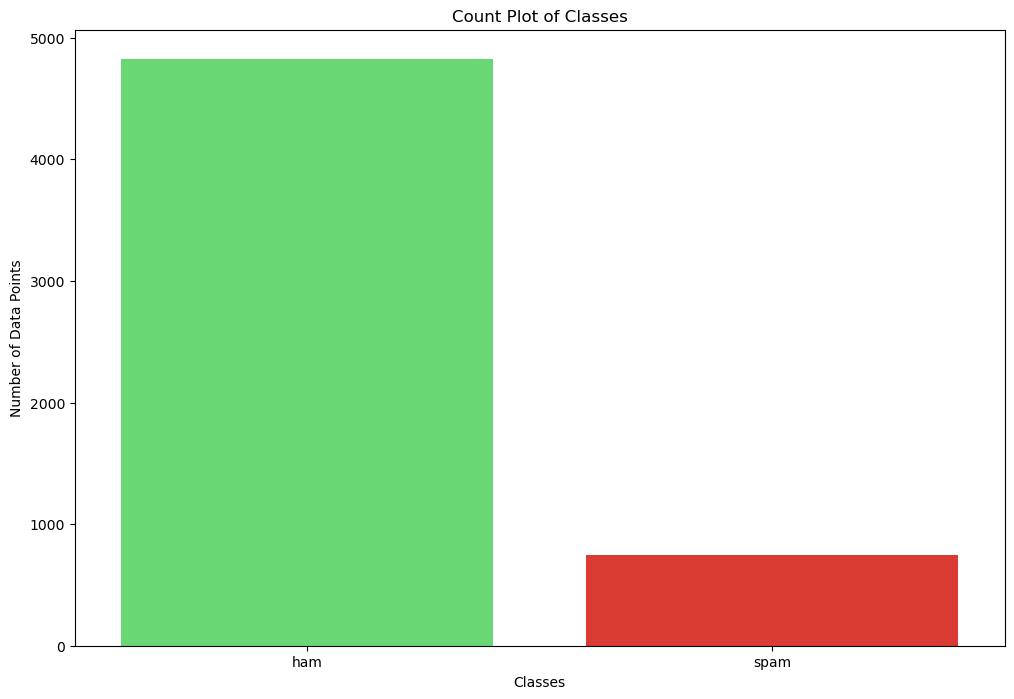

In [7]:
# رسم Count Plot باستخدام Seaborn لعمود 'Target' من DataFrame df
colors = ['#57E964', '#F62217'] # تحديد الألوان التي سيتم استخدامها في الرسم البياني
plt.figure(figsize=(12,8))

fig = sns.countplot(x= df['Target'], palette=colors)
fig.set_title('Count Plot of Classes')
fig.set_xlabel('Classes')
fig.set_ylabel('Number of Data Points')

# حفظ الشكل الذي تم إنشاؤه كصورة PNG في المجلد المحدد "Images"
plt.savefig("Images/Count Plot of Classes.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# إضافة اعمده جديده لعدد الأحرف و الكلمات و الجمل في النصوص الموجودة في عمود 'Text'
nltk.download('punkt') # تحميل الداتا المطلوبه من NLP

df['No_of_Characters'] = df['Text'].apply([lambda row: len(row)]) 
df['No_of_words'] = df['Text'].apply([lambda row: len(word_tokenize(row))])
df['No_of_sentences'] = df['Text'].apply([lambda row: len(sent_tokenize(row))])

df.describe().T # لعرض الإحصاءات

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Adel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0
No_of_sentences,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0


<Figure size 1200x800 with 0 Axes>

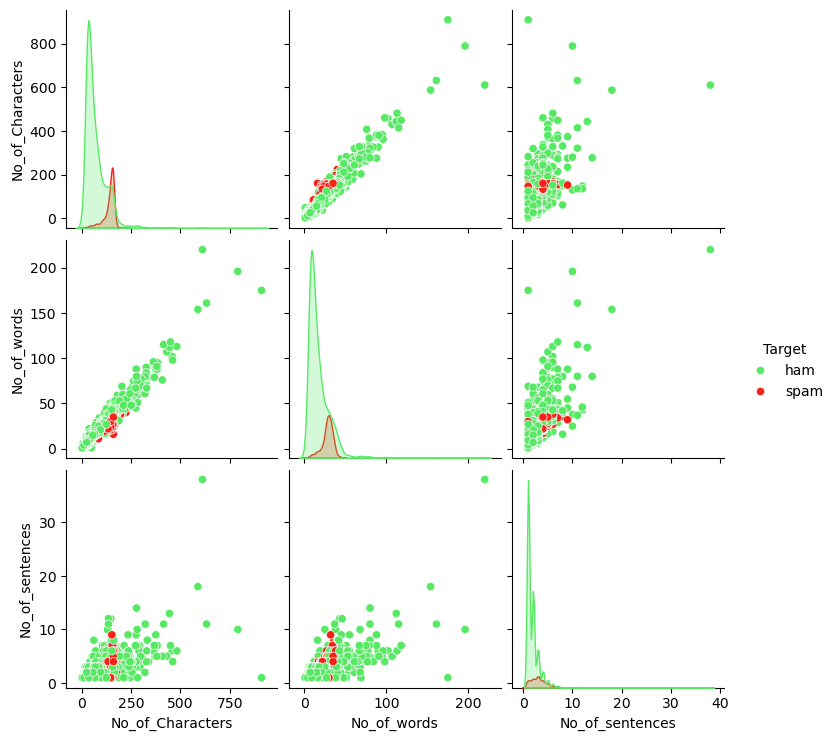

In [9]:
# رسم الـ pairplot باستخدام seaborn ل عرض  العلاقات بين عدد الكلمات و الجمل و الاحرف
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue='Target', palette= colors)

# حفظ الشكل الذي تم إنشاؤه كصورة PNG في المجلد المحدد "Images"
plt.savefig("Images/pairplot_char_word_sent.png", dpi=300, bbox_inches='tight')
plt.show(fg)

In [10]:
# تعريف دالة Clean التي تقوم بتنظيف النصوص 
def Clean(text):
    sms = re.sub('[^a-zA-Z]', ' ', text)    # استبدال كل الحروف غير الأبجدية (أي الأرقام أو الرموز) بمسافة
    
    sms = sms.lower()
    
    sms = sms.split()    # تقسيم النص إلى كلمات (قائمة من الكلمات)
    
    sms = ' '.join(sms)    # دمج الكلمات مرة أخرى إلى نص واحد مفصول بمسافات    
    return sms

# تطبيق دالة Clean على عمود 'Text' في DataFrame وإضافة العمود المنظف 'Clean_Text'
df['Clean_Text'] = df['Text'].apply(Clean)

In [11]:
# تطبيق دالة word_tokenize على النصوص المنظفة (Clean_Text) وتقسيم النصوص إلى كلمات
df['Tokenize_Text'] = df['Clean_Text'].apply([lambda row: word_tokenize(row)])

In [12]:
# تنزيل مجموعة كلمات التوقف (stopwords) من مكتبة NLTK
nltk.download('stopwords')

# تعريف دالة لإزالة كلمات التوقف من النص
def stopword_del(text):
    stop_words = set(stopwords.words("english"))    # تحميل مجموعة كلمات التوقف باللغة الإنجليزية
    removing = [word for word in text if word not in stop_words]
    return removing

# تطبيق الدالة على عمود 'Tokenize_Text' لإنشاء عمود جديد 'Stopwords_Text'
df['Stopwords_Text'] = df['Tokenize_Text'].apply(stopword_del)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# تنزيل مكتبة WordNet من NLTK لاستخدامها في التـ Lemmatization
nltk.download('wordnet')

Lemmatizer = WordNetLemmatizer()    # تعريف ال Lemmatizer لاستخدامه في التـ Lemmatization

# تعريف دالة لعملية الـ Lemmatization
def Lemmatize_text(text):
    # التـ Lemmatization على كل كلمة في النص مع تحديد الجزء اللغوي (في هذه الحالة الفعل 'v')
    lemmatize = [Lemmatizer.lemmatize(word, pos='v') for word in text]
    return lemmatize

# تطبيق دالة التـ Lemmatization على عمود 'Stopwords_Text' وتخزين النتيجة في عمود جديد 'Lemmenated_Text'
df['Lemmenated_Text'] = df['Stopwords_Text'].apply(Lemmatize_text)
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Adel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Target,Text,No_of_Characters,No_of_words,No_of_sentences,Clean_Text,Tokenize_Text,Stopwords_Text,Lemmenated_Text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, live, around, though]"


In [14]:
# تحويل القائمة من الكلمات إلى نص واحد مفصول بمسافات
corpus = []

for i in df['Lemmenated_Text']:
    msg = ' '.join(word for word in i)
    corpus.append(msg)

# عرض محتويات 'corpus' (النصوص المعالجة)
corpus

['go jurong point crazy available bugis n great world la e buffet cine get amore wat',
 'ok lar joke wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf live around though',
 'freemsg hey darling week word back like fun still tb ok xxx std chgs send rcv',
 'even brother like speak treat like aid patent',
 'per request melle melle oru minnaminunginte nurungu vettam set callertune callers press copy friends callertune',
 'winner value network customer select receivea prize reward claim call claim code kl valid hours',
 'mobile months u r entitle update latest colour mobiles camera free call mobile update co free',
 'gon na home soon want talk stuff anymore tonight k cry enough today',
 'six chance win cash pound txt csh send cost p day days tsandcs apply reply hl info',
 'urgent week free membership prize jackpot txt word claim c www dbuk net lccltd pobox ldnw rw',

In [15]:
# استيراد مكتبة TfidfVectorizer و تطبيقها علي النصوص المخزنه في 'corpus'
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()

print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
# استيراد مكتبة LabelEncoder و تطبيقها علي عمود 'Target' لتحويلها الي قيم رقميه
encoder = LabelEncoder()
Y = encoder.fit_transform(df['Target'])

print(Y)

[0 0 1 ... 0 0 0]


In [17]:
# تقسيم البيانات إلى بيانات تدريب وبيانات اختبار:
feature_train, feature_test, target_train, target_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [18]:
# تعريف قائمة تحتوي على أربعة موديلات تصنيفية مختلفة:
Classifier = [SVC(),               # Support Vector Classifier
              RandomForestClassifier(), # Random Forest Classifier
              KNeighborsClassifier(),  # K-Nearest Neighbors Classifier
              MultinomialNB()          # Naive Bayes Classifier
]

# تدريب كل موديل على بيانات التدريب:
for cls in Classifier:
    cls.fit(feature_train, target_train)

# يتم استخدام هذا القاموس لاحقًا للتعرف على اسم الموديل بناءً على الرقم المرتبط به.
index_model = {0: 'SVC', 1: 'Randomforest', 2: 'KNeighbors', 3: 'NavieBayes'}

In [19]:
# يتم حساب درجة الدقة باستخدام cross-validation مع 10 تقسيمات (cv=10) على بيانات التدريب.

for i, model in enumerate(Classifier):
    # حساب درجة الدقة للموديل باستخدام cross-validation
    cv_score = cross_val_score(model, feature_train, target_train, scoring='accuracy', cv=10)
    
    # طباعة اسم الموديل مع المتوسط الحسابي للدقة
    print("%s: %f" % (index_model[i], cv_score.mean()))

SVC: 0.976217
Randomforest: 0.976888
KNeighbors: 0.914740
NavieBayes: 0.966344


In [20]:
# تعريف قوائم فارغة لتخزين قيم Precision, Recall, F1-Score, Test Accuracy الخاصة بكل موديل
precision = []
recall = []
train_accuracy = []
test_accuracy = []
f1score = []

# استخدام كل موديل للتنبؤ بالقيم و حساب قيم Precision, F1-Score, Recall, Score.
for i in Classifier:
    
    target_predict = i.predict(feature_test)
    prec = metrics.precision_score(target_test, target_predict)
    f1_score = metrics.f1_score(target_test, target_predict)
    recal = metrics.recall_score(target_test, target_predict)
    test_acc = i.score(feature_test, target_test)
    
    # إضافة القيم المحسوبة إلى القوائم المخصصة لكل مقياس
    precision.append(prec)
    recall.append(recal)
    test_accuracy.append(test_acc)
    f1score.append(f1_score)

In [21]:
# تعريف قاموس (Dictionary) يحتوي على القيم المحسوبة لكل مقياس: Precision، Recall، F1-Score، و Test Accuracy.
data = {
    'Precision': precision,   # تخزين قيم Precision لكل موديل
    'Recall': recall,         # تخزين قيم Recall لكل موديل
    'F1_Score': f1score,     # تخزين قيم F1-Score لكل موديل
    'Test_Accuracy': test_accuracy  # تخزين قيم Test Accuracy لكل موديل
}

# تحويل القاموس إلى DataFrame باستخدام pandas مع تحديد أسماء الأعمدة.
Results = pd.DataFrame(data, index=[index_model[i] for i in range(len(index_model))])

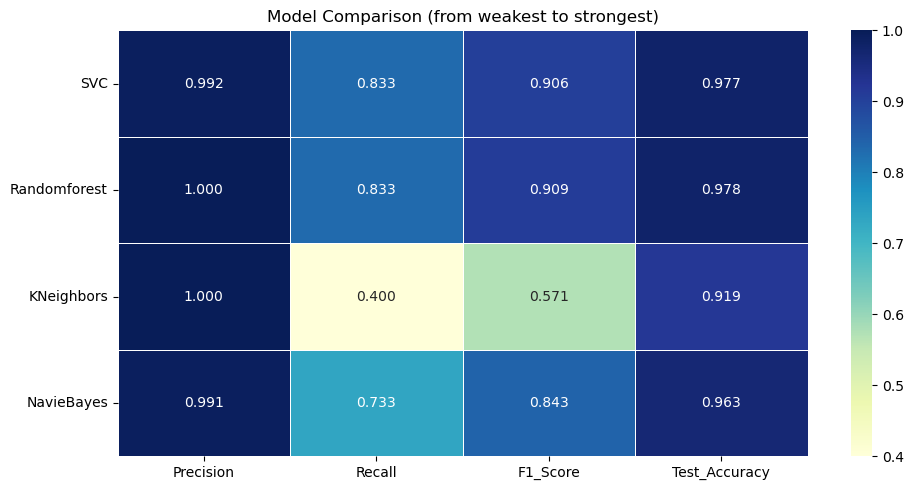

In [34]:
# إنشاء heatmap باستخدام seaborn لعرض بيانات المقارنة بين الموديلات

plt.figure(figsize=(10, 5)) 
sns.heatmap(Results, annot=True, fmt=".3f", cmap="YlGnBu", linewidths=0.5,
            vmin=Results.min().min(), vmax=Results.max().max())  
            
# annot=True: يقوم بعرض القيم داخل الخلايا في الـ heatmap.
# fmt=".3f": تحديد تنسيق الأرقام المعروضة بحيث تكون إلى 3 خانات عشرية.
# cmap="YlGnBu": تحديد مخطط الألوان المستخدم في الـ heatmap.
# linewidths=0.5: تحديد سمك الخطوط بين الخلايا.
# vmin=Results.min().min() و vmax=Results.max().max(): تحديد قيم الحد الأدنى والحد الأقصى للألوان بناءً على القيم في الـ DataFrame. 

plt.title("Model Comparison (from weakest to strongest)")
plt.yticks(rotation= 0)
plt.tight_layout()   # تحسين التنسيق 
plt.savefig("Images/model_comparison_heatmap_ranked.png", dpi=300)
plt.show()

In [38]:
# حفظ ال Model, TF-IDF, LabelEncoder باستخدام Pickle
with open('Model/model.pkl', 'wb') as file:
    pickle.dump(model, file)

with open('Model/tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

with open('Model/label_encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)